[Source:](https://arxiv.org/pdf/1904.11955)

Let $\sigma : \mathbb{R} \to \mathbb{R}$ be the activation function, and $\mathcal{T}_\sigma : S^+ \to S^+$ be the operator induced by $\sigma$,
\begin{align*}
\forall x, x' \in \mathbb{R}^d, \quad \mathcal{T}_\sigma(K)(x, x') = c_\sigma \mathbb{E}_{(u,v) \sim \mathcal{N}(0, K|_{x,x'})} [\sigma(u)\sigma(v)],
\end{align*}
where $K|_{x,x'} \in \mathbb{R}^{2 \times 2}$, $K|_{x,x'} = \begin{bmatrix} K(x,x) & K(x,x') \\ K(x',x) & K(x',x') \end{bmatrix}$.

For convenience, we use $t_\sigma(\Sigma)$ to denote $c_\sigma \mathbb{E}_{(u,v) \sim \mathcal{N}(0, \Sigma)}[\sigma(u)\sigma(v)]$, and define $\hat{t}_\sigma(\rho)$ as
\begin{align*}
\hat{t}_\sigma(\rho) = c_\sigma \mathbb{E}_{(u,v) \sim \Sigma'}[\sigma(u)\sigma(v)], \text{ with } \Sigma' = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}
\end{align*}

When $\sigma$ is $k$-homogeneous function, we have
\begin{align*}
t_\sigma(\Sigma) = c_\sigma (\Sigma_{11}\Sigma_{22})^{\frac{k}{2}} \mathbb{E}_{(u,v) \sim \mathcal{N}(0, \Sigma')}[\sigma(u)\sigma(v)] \text{ with } \Sigma' = \begin{bmatrix} 1 & \frac{\Sigma_{12}}{\sqrt{\Sigma_{11}\Sigma_{22}}} \\ \frac{\Sigma_{12}}{\sqrt{\Sigma_{11}\Sigma_{22}}} & 1 \end{bmatrix}.
\end{align*}

Thus $t_\sigma(\Sigma)$ can be written as $c_\sigma (\Sigma_{11}\Sigma_{22})^{\frac{k}{2}} \hat{t}_\sigma(\frac{\Sigma_{12}}{\sqrt{\Sigma_{11}\Sigma_{22}}})$.


I have used above formulation for calculation of $\Theta_{theory}$ and for $k=1$




Width 5 	 Relative Error: 5.576512
Width 10 	 Relative Error: 2.077755
Width 20 	 Relative Error: 0.857025
Width 50 	 Relative Error: 0.323428
Width 100 	 Relative Error: 0.164778
Width 150 	 Relative Error: 0.110164
Width 200 	 Relative Error: 0.083464
Width 250 	 Relative Error: 0.066760
Width 300 	 Relative Error: 0.054995
Width 500 	 Relative Error: 0.033588
Width 700 	 Relative Error: 0.024326
Width 800 	 Relative Error: 0.021150
Width 900 	 Relative Error: 0.018708
Width 1000 	 Relative Error: 0.016919
Width 1500 	 Relative Error: 0.011211
Width 2000 	 Relative Error: 0.008356
Width 3000 	 Relative Error: 0.005611
Width 5000 	 Relative Error: 0.003370
Width 8000 	 Relative Error: 0.002110
Width 10000 	 Relative Error: 0.001692


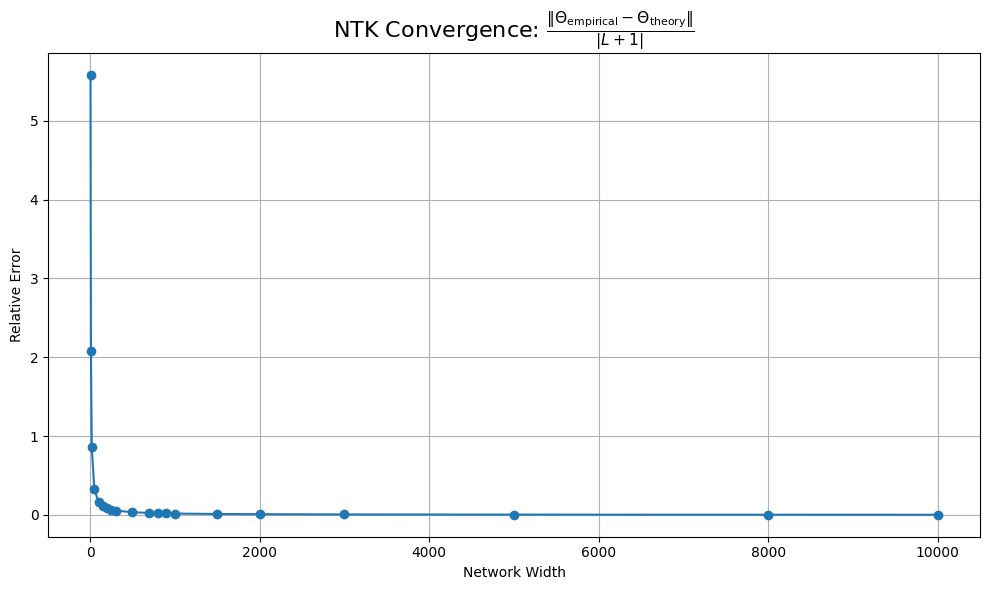

[5.576511859893799,
 2.0777549743652344,
 0.8570250272750854,
 0.32342827320098877,
 0.1647777408361435,
 0.11016380786895752,
 0.08346408605575562,
 0.06675969064235687,
 0.05499475449323654,
 0.03358840197324753,
 0.024326305836439133,
 0.021150436252355576,
 0.018707871437072754,
 0.016919352114200592,
 0.011211019940674305,
 0.008356017991900444,
 0.005611416418105364,
 0.003370437305420637,
 0.002110202331095934,
 0.0016918836627155542]

In [4]:
import torch
import numpy as np
from typing import Optional, Tuple, List, Union
from torch.func import functional_call, vmap, grad, jacrev
import torch.nn.functional as F


def relu_kernel_covariance(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
    
    Implements formula from Fact E.1:
    tˆσ(ρ) = (√(1−ρ²) + ρ·arcsin(ρ))/π + ρ/2
    where cσ = 2
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute correlation coefficient (ρ)
    rho = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    rho = torch.clamp(rho, -1.0 + 1e-6, 1.0 - 1e-6)  # Numerical stability
    
    # Implement tˆσ(ρ) directly using the formula from Fact E.1.3
    sqrt_term = torch.sqrt(1 - rho**2)
    arcsin_term = torch.arcsin(rho)
    t_sigma = (sqrt_term + rho * arcsin_term) / np.pi + rho / 2
    
    # Apply c_σ = 2 and scale by the norms
    return 2 * (k_xx * k_yy)**(1/2) * t_sigma ## 1/2 for k=1 from k-Homogenous Function property

def relu_kernel_derivative(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ̇^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
        
    Implements formula from Fact E.1:
    tˆσ̇(ρ) = 1/2 + arcsin(ρ)/π
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute correlation coefficient (ρ)
    rho = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    rho = torch.clamp(rho, -1.0 + 1e-6, 1.0 - 1e-6)  # Numerical stability
    
    # Implement tˆσ̇(ρ) directly using the formula from Fact E.1.3
    return 0.5 + torch.arcsin(rho) / np.pi

def theoretical_ntk(X1: torch.Tensor, 
                    X2: Optional[torch.Tensor] = None, 
                    L: int = 2) -> torch.Tensor:
    """
    Compute theoretical NTK for fully-connected neural network with ReLU activation.
    
    Args:
        X1: Input tensor of shape (n1, d)
        X2: Input tensor of shape (n2, d), if None, X2 = X1
        L: Number of hidden layers in the network
    
    Returns:
        Θ: Theoretical NTK matrix of shape (n1, n2)
    """
    if X2 is None:
        X2 = X1

    # Normalize inputs by input dimension (needed for consistent scaling)
    X1 = X1 / np.sqrt(X1.shape[1])
    X2 = X2 / np.sqrt(X2.shape[1])
    
    n1, n2 = X1.shape[0], X2.shape[0]
    Sigma = torch.zeros((L+1, n1, n2), dtype=X1.dtype)
    Sigma_dot = torch.zeros((L+1, n1, n2), dtype=X1.dtype)
    Theta = torch.zeros((n1, n2), dtype=X1.dtype)
    
    # Compute initial kernel: Σ^(0)(x,x') = x^T x'
    Sigma[0] = X1 @ X2.T
    
    # Recursively compute covariance matrices for each layer
    for h in range(1, L+1):
        for i in range(n1):
            for j in range(n2):
                # Build 2x2 covariance matrix for pair (x_i, x_j)
                Lambda = torch.tensor([
                    [Sigma[h-1, i, i], Sigma[h-1, i, j]],
                    [Sigma[h-1, i, j], Sigma[h-1, j, j]]
                ])

                # Compute next-layer covariance
                Sigma[h, i, j] = relu_kernel_covariance(Lambda)
                
                # Compute derivative covariance
                Sigma_dot[h, i, j] = relu_kernel_derivative(Lambda)
    
    # Compute the NTK using equation (9)
    for h in range(1, L+1):
        # Extract Σ^(h-1)(x,x')
        sigma_term = Sigma[h-1]
        
        # Compute product of derivative terms
        deriv_product = torch.ones((n1, n2), device=X1.device, dtype=X1.dtype)
        for h_prime in range(h, L+1):
            deriv_product *= Sigma_dot[h_prime]
        
        # Add contribution from this layer
        Theta += sigma_term * deriv_product
    
    return Theta

def compare_ntk_empirical_vs_theoretical(X, width_list=None):
    """
    Compare empirical NTK with theoretical NTK across different widths
    
    Args:
        X: Input data tensor of shape (n, d)
        width_list: List of network widths to test
    
    Returns:
        Plots comparing empirical and theoretical NTK
    """
    if width_list is None:
        width_list = [5, 10, 20, 50, 100, 150, 200, 250, 300, 500, 700, 800, 900, 1000, 1500, 2000, 3000, 5000, 8000, 10000, ]
    
    # Compute theoretical NTK once (constant regardless of width)
    K_theory = theoretical_ntk(X, L=2)
    
    rel_errors = []
    
    for width in width_list:
        # Set random seed for reproducibility
        torch.manual_seed(42)

        # Initialize parameters for a 2-layer network
        W1 = torch.randn(width, X.shape[1]) / np.sqrt(X.shape[1]/2)
        b1 = torch.zeros(width)
        W2 = torch.randn(1, width) / np.sqrt(width)
        b2 = torch.zeros(1)

        def f(x, W1, W2, b1, b2):
          layer1 = F.relu(x@(W1.T)+b1)
          layer2 = layer1@(W2.T)+b2
          layer2 = layer2.view(-1)
          return layer2


        jacobian = jacrev(f, argnums= (1, 2, 3, 4))(X, W1, W2, b1, b2)
        K_emp = torch.stack([j.flatten(1)@k.flatten(1).T for j,k in zip(jacobian, jacobian)]).sum(0)
        
        
        # Scale empirical NTK appropriately
        K_emp = K_emp / width
        
        # Compute relative error
        rel_error = torch.norm(K_emp - K_theory) / torch.tensor(width + 1)
        rel_errors.append(rel_error.item())
        
        print(f"Width {width} \t Relative Error: {rel_error:.6f}")
    
    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(width_list, rel_errors, 'o-')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Network Width')
    plt.ylabel('Relative Error')
    plt.title(r'NTK Convergence: $\frac{\| \Theta_{\text{empirical}} - \Theta_{\text{theory}} \|}{ | L + 1 | }$', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rel_errors

# Example usage:
X = torch.randn(50, 20)  # 10 samples, 20 features
compare_ntk_empirical_vs_theoretical(X)
